In [1]:
import pandas as pd
import itertools
import hashlib
from tqdm import tqdm


In [2]:
df = pd.read_csv('../files/atchley.csv')
df.set_index('amino.acid', inplace=True)
atchley_features = df.to_dict(orient='index')
for key, value in atchley_features.items():
    atchley_features[key] = list(value.values())

In [3]:
def hash_sequences(mutations_lst, hash_method):
    new_lst = []
    for row in tqdm(mutations_lst, desc="hashing sequences"):
        hash_value = hash_method(row[0])
        new_lst.append([row[0], hash_value, row[2]])
    return new_lst

In [4]:
def hash_atchley_sha_int(sequence):

    hash_input = ''
    for aa in sequence:
        hash_input += ''.join(map(str, atchley_features.get(aa)))
    hash_object = hashlib.sha256(hash_input.encode())
    hash_digest = hash_object.digest()
    
    # Convert the hexadecimal digest to a decimal number
    hash_number = int.from_bytes(hash_digest, byteorder='big')
    return hash_number

In [5]:
def generate_mutations(sequence, number, mutations_lst):
    mutations_lst.append([sequence, 0, ""])
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    for i in range(1, number + 1):
        for positions in itertools.combinations(range(len(sequence)), i):
            for new_aas in itertools.product(aa, repeat=i):
                mutated_sequence = list(sequence)
                for pos, new_aa in zip(positions, new_aas):
                    mutated_sequence[pos] = new_aa
                mutated_sequence = "".join(mutated_sequence)
                if mutated_sequence != sequence:
                    mutations_lst.append([mutated_sequence, 0, sequence])
                    # mutations_df = mutations_df.append({'mutation': mutated_sequence, 'original': sequence}, ignore_index=True)

    return mutations_lst


In [6]:
def find_duplicates(lst):
    sorted_lst = sorted(lst)
    duplicates = []
    for i in range(1, len(sorted_lst)):
        if sorted_lst[i] == sorted_lst[i - 1]:
            duplicates.append(sorted_lst[i])
    return duplicates

In [7]:
def get_distance(seq1, seq2, distances_df):
    distance = sum([distances_df.loc[aa1, aa2] for aa1, aa2 in zip(seq1, seq2) if aa1 != aa2])
    return distance

In [8]:
sequence_map = {}

sequences_csv = '../files/forchen_F_26L.csv'
sequences_header = "cdr3_amino_acid"

# sequences_csv = '../files/for_chen_B.csv'
# sequences_header = "CDR3.aa"

# sequences_csv = "../random_sequences.csv"
# sequences_header = "sequences"

mutations_df = pd.DataFrame(columns=['mutation','mutation_hash' 'original'])

sequences_df = pd.read_csv(sequences_csv)
sequences_set = set(sequences_df[sequences_header].unique())
# sequences_hashed = hash_sequences(sequences_set, hash_atchley_sha_int,sequence_map)



In [9]:

max_mutations = 2
couples = {}
# pd.DataFrame(columns=['mutation','mutation_hash' 'original'])
mutations_lst = []


for seq in tqdm(sequences_set, desc="generating mutations"):
    couples[seq] = []
    mutations_lst = generate_mutations(seq, max_mutations, mutations_lst)

    # combined = sequences_hashed + mutations_hashed
    # combined.sort()
    # duplicates = find_duplicates(combined)
    # if duplicates:
    #     for dup in duplicates:
    #         dup = sequence_map[dup]
    #         couples[seq].append([dup, get_distance(seq, dup)])
mutations_lst = hash_sequences(mutations_lst, hash_atchley_sha_int)

generating mutations:   0%|          | 0/1178 [00:00<?, ?it/s]

generating mutations:  79%|███████▉  | 928/1178 [03:15<24:18,  5.83s/it]

: 

In [197]:
# Create a DataFrame
mutations_df = pd.DataFrame(mutations_lst, columns=['mut', 'mut_hash', 'org'])

In [199]:
mutations_sorted = mutations_df.sort_values(by='mut_hash')

In [226]:
distances_csv = "../distance_matrix.csv"
distances_df = pd.read_csv(distances_csv, index_col=0)

couples = {}

for seq in tqdm(sequences_set, "finding close sequences"):
    # print(seq)
    # find duplicates
    couples[seq] = []
    filtered_df = mutations_sorted[(mutations_sorted['org'] == seq)\
                                    | (mutations_sorted['org'] == "")]
    duplicate_values = filtered_df[filtered_df.duplicated(['mut_hash'])]

    for dup in duplicate_values['mut']:
        couples[seq].append([dup, get_distance(seq, dup, distances_df)])
    # if not duplicate_values.empty:

    #     print(duplicate_values[['mut', 'org']])

finding close sequences: 100%|██████████| 1178/1178 [00:48<00:00, 24.33it/s]


In [227]:
couples = {key: sorted(value, key=lambda x: x[1]) for key, value in couples.items()}

In [1]:
import json

with open("../couples.json") as json_file:
    couples = json.load(json_file)


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

max_neig = 1
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    count = 0
    for neighbor, weight in neighbors:
        if count < max_neig:
            G.add_edge(node, neighbor, weight=weight)
            count += 1

In [7]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

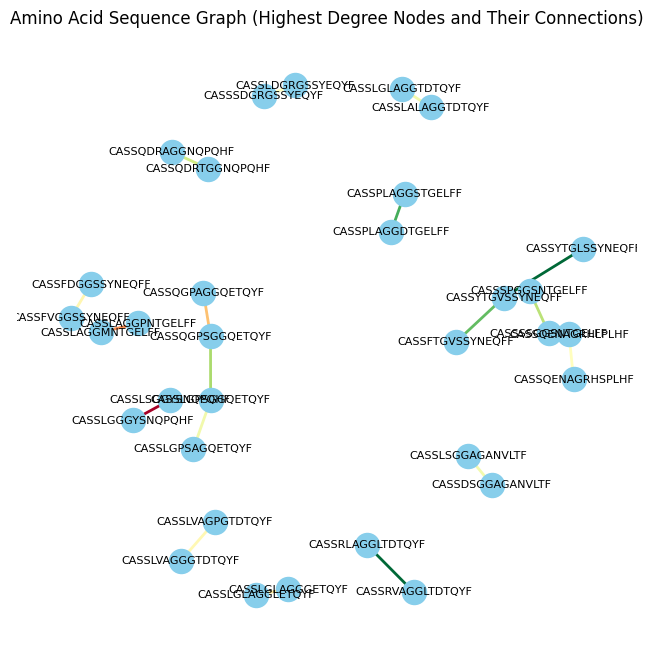

In [8]:

edge_colors = get_edges_colors(G)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.3, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_highest_degree_with_connections.png')
plt.show()

### Highest degree node

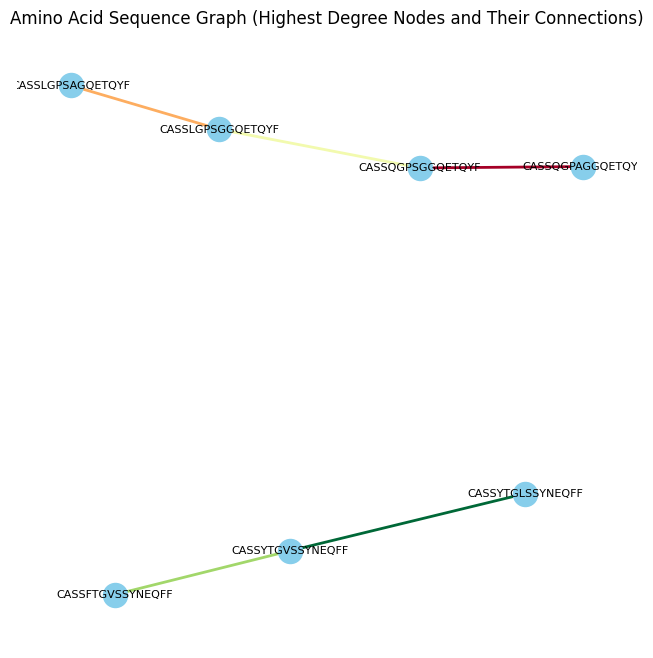

In [9]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_highest_degree_with_connections.png')
plt.show()


### Longest path

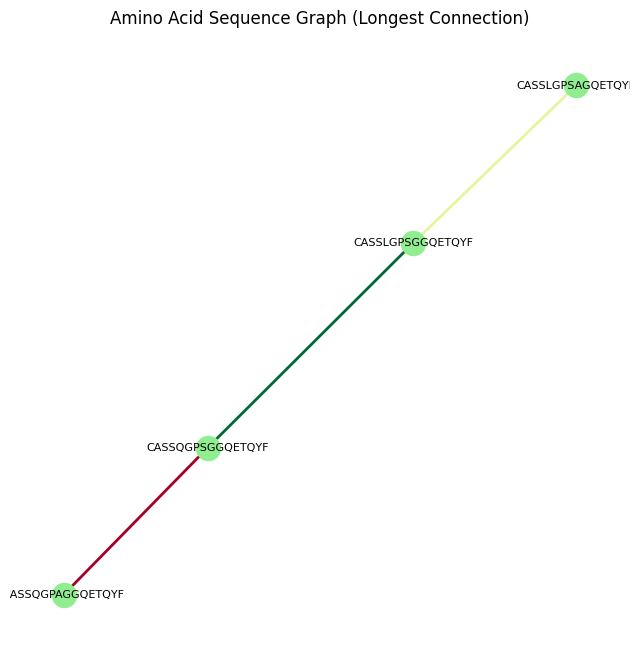

In [234]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_longest_connection.png')
plt.show()